# **NB 5.3: Sentiment Analysis Over time - After BERT Topic Modeling**

In [5]:
# Standard Inputs

import sklearn
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics

from joblib import dump, load
from joblib import Parallel, delayed

In [6]:
# Multiprocessing

#pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=True )

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [7]:
# Imports the Google Cloud client library

from google.cloud import storage
# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = "nlp_final_project_kshitijm"

# Creates the new bucket
bucket = storage_client.bucket(bucket_name)
print(f"Bucket {bucket.name} connected.")

Bucket nlp_final_project_kshitijm connected.


In [26]:
#Visuals

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings("ignore")

## Importing data files

In [9]:
%%time

### Loading positive and negative sentiment datasets

df_filt_pos=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7_POS_BERTopics_Sentiments_NER.csv',lineterminator='\n')
df_filt_neg=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7_NEG_BERTopics_Sentiments_NER.csv',lineterminator='\n')

CPU times: user 43.2 s, sys: 8.9 s, total: 52.1 s
Wall time: 2min 14s


In [36]:
%%time

### Loading an older data file with all articles
df4_samp=pd.read_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data4_filtered.parquet')


CPU times: user 1min 10s, sys: 1min 1s, total: 2min 12s
Wall time: 2min 1s


In [55]:
articles_period=df4_samp.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
articles_period.rename(columns={'url':'count_total_articles'}, inplace=True)
articles_period[0:5]

,year_pub,month,month-year,count_total_articles
0,2020,1,Jan 2020,2886
1,2020,2,Feb 2020,2745
2,2020,3,Mar 2020,3083
3,2020,4,Apr 2020,2961
4,2020,5,May 2020,2910


In [54]:
pos_articles_period=df_filt_pos.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_articles_period.rename(columns={'url':'count_pos_articles'}, inplace=True)
pos_articles_period[0:5]

,year_pub,month,month-year,count_pos_articles
0,2020,1,Jan 2020,876
1,2020,2,Feb 2020,748
2,2020,3,Mar 2020,936
3,2020,4,Apr 2020,869
4,2020,5,May 2020,764


In [53]:
neg_articles_period=df_filt_neg.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
neg_articles_period.rename(columns={'url':'count_neg_articles'}, inplace=True)
neg_articles_period[0:5]

,year_pub,month,month-year,count_neg_articles
0,2020,1,Jan 2020,79
1,2020,2,Feb 2020,76
2,2020,3,Mar 2020,71
3,2020,4,Apr 2020,48
4,2020,5,May 2020,58


In [64]:
articles_sents=articles_period.merge(pos_articles_period['count_pos_articles'], left_on=articles_period['month-year'], right_on=pos_articles_period['month-year'], how='left')
articles_sents.drop(['key_0'], axis=1, inplace=True)
articles_sents=articles_sents.merge(neg_articles_period['count_neg_articles'], on=articles_sents['month-year'], how='left')
articles_sents.drop(['key_0'], axis=1, inplace=True)

articles_sents['prop_pos_articles']=np.round((articles_sents['count_pos_articles']/articles_sents['count_total_articles'])*100,2)
articles_sents['prop_neg_articles']=np.round((articles_sents['count_neg_articles']/articles_sents['count_total_articles'])*100,2)

articles_sents
# articles_sents.merge(neg_articles_period['count_neg_articles'], on=articles_sents['month-year'], how='left')

,year_pub,month,month-year,count_total_articles,count_pos_articles,count_neg_articles,prop_pos_articles,prop_neg_articles
0,2020,1,Jan 2020,2886,876,79,30.35,2.74
1,2020,2,Feb 2020,2745,748,76,27.25,2.77
2,2020,3,Mar 2020,3083,936,71,30.36,2.30
3,2020,4,Apr 2020,2961,869,48,29.35,1.62
4,2020,5,May 2020,2910,764,58,26.25,1.99
5,2020,6,Jun 2020,1786,525,35,29.40,1.96
6,2020,7,Jul 2020,2073,567,53,27.35,2.56
7,2020,8,Aug 2020,2191,614,49,28.02,2.24
8,2020,9,Sep 2020,2634,797,43,30.26,1.63
9,2020,10,Oct 2020,3170,958,48,30.22,1.51


In [100]:
articles_sents.to_csv('articles_sents.csv')

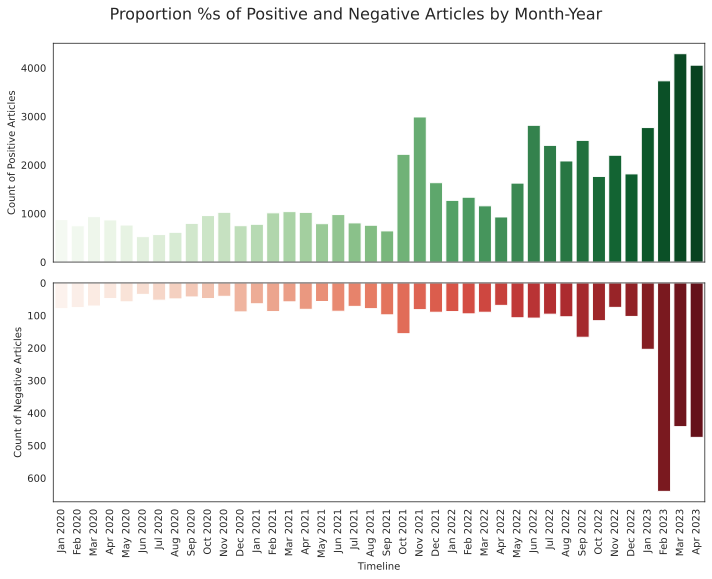

In [97]:
fig,axes=plt.subplots(2,1,figsize=(10, 8), sharex=True)
axes=axes.flatten()

green_palette = sns.color_palette('Greens', n_colors=len(articles_sents['month-year'].unique()))
red_palette = sns.color_palette('Reds', n_colors=len(articles_sents['month-year'].unique()))

sns.barplot(x=articles_sents['month-year'],y=articles_sents['count_pos_articles'], ax=axes[0], palette=green_palette)
sns.barplot(x=articles_sents['month-year'],y=articles_sents['count_neg_articles'], ax=axes[1], palette=red_palette)

plt.xticks(rotation=90)

axes[0].set_ylabel('Count of Positive Articles')
axes[0].set_xlabel('')  # Remove x-axis label from the upper subplot

# axes[0].set_title('Postitive Articles Count by Month-Year')
# axes[0].set_xlabel('Count of Positive Articles')


axes[1].set_ylabel('Count of Negative Articles')
axes[1].set_xlabel('Timeline')

# axes[1].set_title('Negative Articles Count by Month-Year')
axes[1].invert_yaxis()

fig.suptitle('Counts of Positive and Negative Articles by Month-Year', fontsize=16, y=1)

# Show the plot
plt.tight_layout()
plt.show()

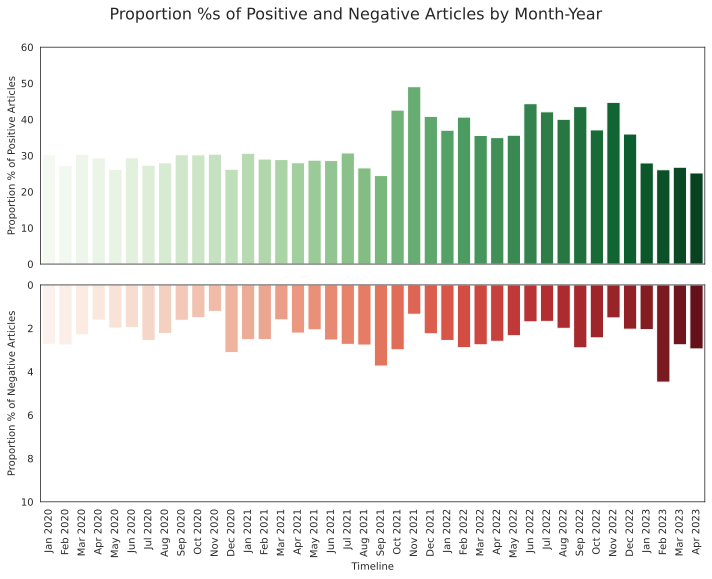

In [99]:
fig,axes=plt.subplots(2,1,figsize=(10, 8), sharex=True)
axes=axes.flatten()

green_palette = sns.color_palette('Greens', n_colors=len(articles_sents['month-year'].unique()))
red_palette = sns.color_palette('Reds', n_colors=len(articles_sents['month-year'].unique()))

sns.barplot(x=articles_sents['month-year'],y=articles_sents['prop_pos_articles'], ax=axes[0], palette=green_palette)
sns.barplot(x=articles_sents['month-year'],y=articles_sents['prop_neg_articles'], ax=axes[1], palette=red_palette)

plt.xticks(rotation=90)

axes[0].set_ylabel('Proportion % of Positive Articles')
axes[0].set_xlabel('')  # Remove x-axis label from the upper subplot
axes[0].set_ylim(0, 60)  # Set y-axis limits for the upper subplot

# axes[0].set_title('Postitive Articles Count by Month-Year')
# axes[0].set_xlabel('Count of Positive Articles')


axes[1].set_ylabel('Proportion % of Negative Articles')
axes[1].set_xlabel('Timeline')
axes[1].set_ylim(0, 10)  # Set y-axis limits for the lower subplot

# axes[1].set_title('Negative Articles Count by Month-Year')
axes[1].invert_yaxis()

fig.suptitle('Proportion %s of Positive and Negative Articles by Month-Year', fontsize=16, y=1)


# Show the plot
plt.tight_layout()
plt.show()

In [11]:
df_filt_neg.head(2)

,Unnamed: 0.1,Unnamed: 0,url,date,language,title,text,cleaned_text,article_source,clean_title,...,sent_probs,sent_label,entities_spacy,ENT_ORG,ENT_PROD,ENT_PER,ENT_NORP,cleaned_tokens_string,Bert_topics,Bert_topics_words
0,122.0,122,https://www.indiatvnews.com/business/news-all-...,2020-01-26,en,"All eyes on AI EoI on Monday, likely suitors a...","All eyes on AI EoI on Monday, likely suitors...","All eyes on AI EoI on Monday, likely suitors a...",Business News – India TV,"All eyes on AI EoI on Monday, likely suitors a...",...,[[0.8221568 0.17587517 0.00196806]],0,"[('AI EoI', 'ORG'), ('Monday', 'DATE'), ('Tata...","['AI EoI', 'Tatas', 'tubeLive TVLatest News E...","['Galaxy Note', 'Galaxy S10 Lite', 'Galaxy S10...","['TVSunday', 'NewsBusiness NewsAll', 'Rajan Me...",['English'],eyes ai eoi monday likely suitors tatas newsin...,32,"[('india', 0.040011126290172026), ('air', 0.03..."
1,131.0,131,https://www.americanbankingnews.com/2020/01/03...,2020-01-03,en,Matrix AI Network (MAN) Market Cap Reaches $4....,\nMatrix AI Network (MAN) Market Cap Reaches $...,Matrix AI Network N Market Cap Reaches 4.93 M...,American Banking News,Matrix AI Network (MAN) Market Cap Reaches $4....,...,[[0.8037224 0.04957912 0.14669852]],0,"[('Matrix AI Network N Market Cap', 'ORG'), ('...","['Matrix AI Network N Market Cap', 'MillionAme...","['Matrix AI Networks', 'Matrix AI Network Toke...","['FilingsDaily RatingsNews', 'Rubycoin RBY', '...","['Ethfinex', 'Polymath', 'Ethfinex', 'Rubycoin']",matrix ai network man market cap reaches milli...,22,"[('matrix', 0.0913245002472763), ('network', 0..."
